In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgbm
import xgboost as xgb
import optuna
import mlflow

In [243]:
train_data = pd.read_csv('train.csv', index_col='PassengerId')
test_data = pd.read_csv('test.csv', index_col='PassengerId')
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


# EDA

# 1.1. Overview

In [244]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [245]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [246]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [247]:
test_data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


# 1.2. Missing values

# Train data

In [248]:
all_features_train = train_data.columns.to_list()
nan_values_train = {}

for feature in all_features_train:
    num_nan_values = train_data[feature].isna().sum()
    nan_values_train[feature] = num_nan_values

print(nan_values_train)

{'Survived': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 0, 'Cabin': 687, 'Embarked': 2}


1.2.1. Age

In [249]:
# filling out 'Age' NaNs with median values based on Pclass and Sex
median_age = train_data.groupby(['Pclass', 'Sex'])['Age'].median()

for pclass in range(1,4):
    for sex in ['female', 'male']:
        print(f"Median age of Pclass {pclass} {sex}: {median_age[pclass, sex]}")

train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

Median age of Pclass 1 female: 35.0
Median age of Pclass 1 male: 40.0
Median age of Pclass 2 female: 28.0
Median age of Pclass 2 male: 30.0
Median age of Pclass 3 female: 21.5
Median age of Pclass 3 male: 25.0


1.2.2. Embarked

In [250]:
# filling out 'Embarked' NaNs with most common value
train_data['Embarked'] = train_data['Embarked'].fillna('S')

1.2.3. Cabin

In [251]:
# removing feature 'Cabin', because more than 80% values are missing
train_data = train_data.drop(columns=['Cabin'])

# Test data

In [252]:
all_features_test = test_data.columns.to_list()
nan_values_test = {}

for feature in all_features_test:
    num_nan_values = test_data[feature].isna().sum()
    nan_values_test[feature] = num_nan_values

print(nan_values_test)

{'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 86, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 1, 'Cabin': 327, 'Embarked': 0}


1.2.1. Age

In [253]:
# filling out 'Age' NaNs with median train values based on Pclass and Sex
test_data['Age'] = test_data.apply(lambda row: median_age[row['Pclass'], row['Sex']] if pd.isnull(row['Age']) else row['Age'], axis=1)

1.2.2. Fare

In [254]:
test_data[test_data['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [255]:
# filling out 'Fare' NaN with median value based on Pclass and Sex for this person
median_fare = train_data.groupby(['Pclass', 'Sex'])['Fare'].median()[3, 'male']
test_data['Fare'] = test_data['Fare'].fillna(median_fare)

1.2.3. Cabin

In [256]:
# removing feature 'Cabin', because more than 80% values are missing
test_data = test_data.drop(columns=['Cabin'])

# 1.3. Some EDA in order to understand the data

* Numerical feature distributions

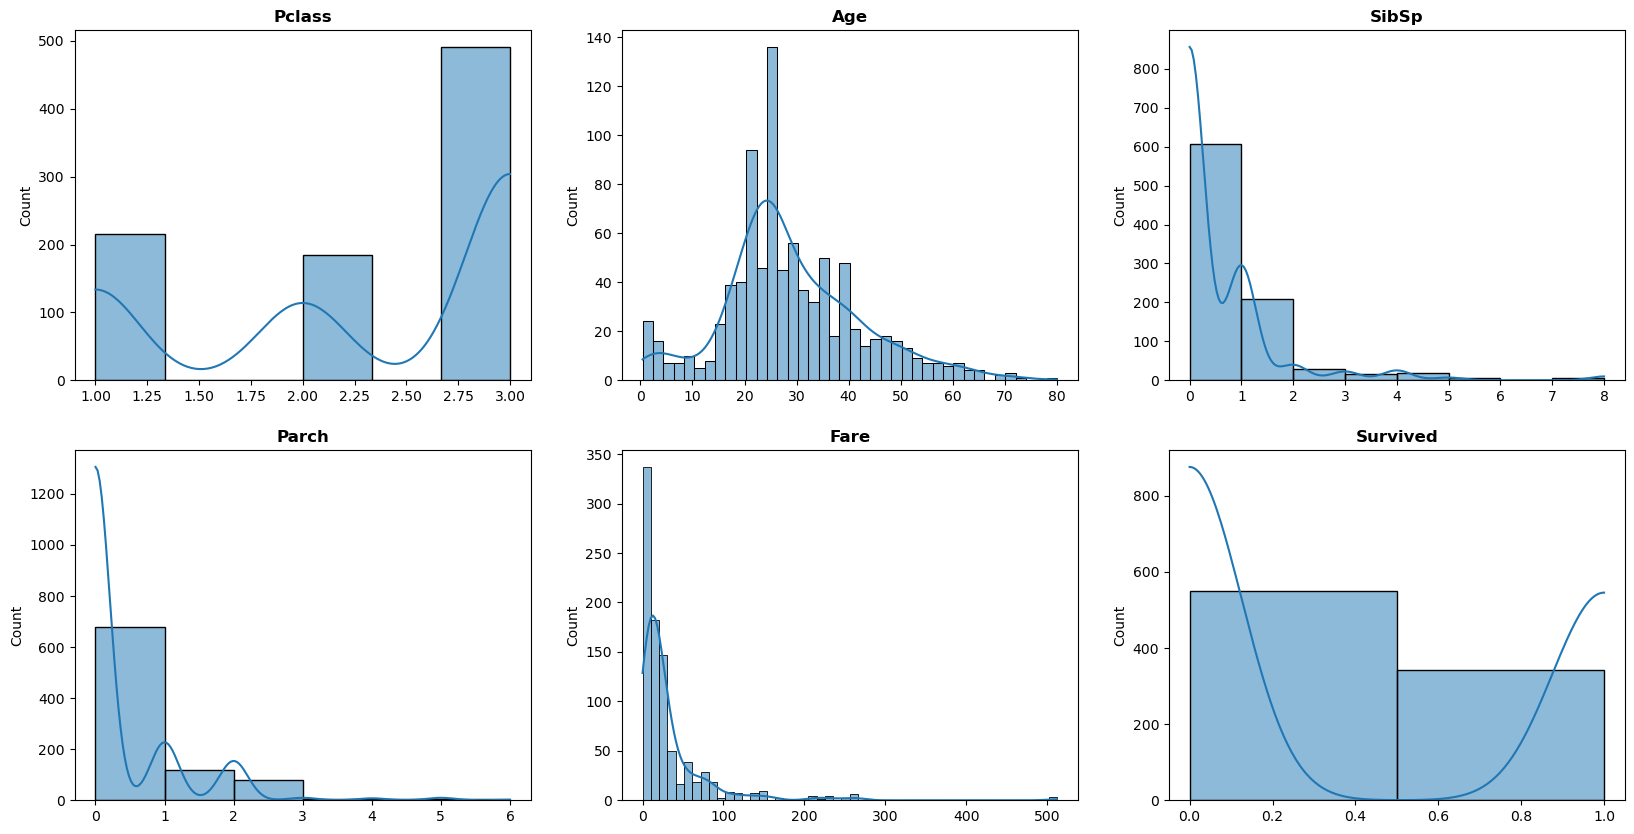

In [257]:
_, axis = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
sns.histplot(train_data['Pclass'], bins=6, kde=True, ax=axis[0,0])
axis[0,0].set_title('Pclass', fontweight='bold')
axis[0,0].set_xlabel('')

sns.histplot(train_data['Age'], bins=40, kde=True, ax=axis[0,1])
axis[0,1].set_title('Age', fontweight='bold')
axis[0,1].set_xlabel('')

sns.histplot(train_data['SibSp'], bins=8, kde=True, ax=axis[0,2])
axis[0,2].set_title('SibSp', fontweight='bold')
axis[0,2].set_xlabel('')

sns.histplot(train_data['Parch'], bins=6, kde=True, ax=axis[1,0])
axis[1,0].set_title('Parch', fontweight='bold')
axis[1,0].set_xlabel('')

sns.histplot(train_data['Fare'], bins=50, kde=True, ax=axis[1,1])
axis[1,1].set_title('Fare', fontweight='bold')
axis[1,1].set_xlabel('')

# Target distribution
sns.histplot(train_data['Survived'], bins=2, kde=True, ax=axis[1,2])
axis[1,2].set_title('Survived', fontweight='bold')
axis[1,2].set_xlabel('')

plt.show()

* Categorical features

In [258]:
unique_values = {}
categorical_features = ['Name', 'Sex', 'Ticket', 'Embarked']

for cat_feature in categorical_features:
    unique_n = train_data[cat_feature].nunique()
    unique_values[cat_feature] = unique_n

print(unique_values)

{'Name': 891, 'Sex': 2, 'Ticket': 681, 'Embarked': 3}


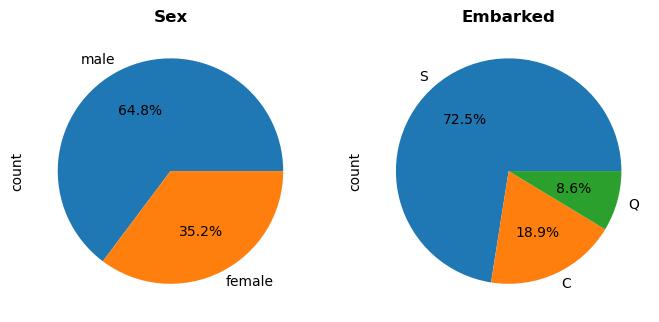

In [259]:
_, axis = plt.subplots(ncols=2, figsize=(8,4))
train_data['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axis[0])
axis[0].set_title('Sex', fontweight='bold')

train_data['Embarked'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axis[1])
axis[1].set_title('Embarked', fontweight='bold')
plt.show()

# 1.4. Correlations

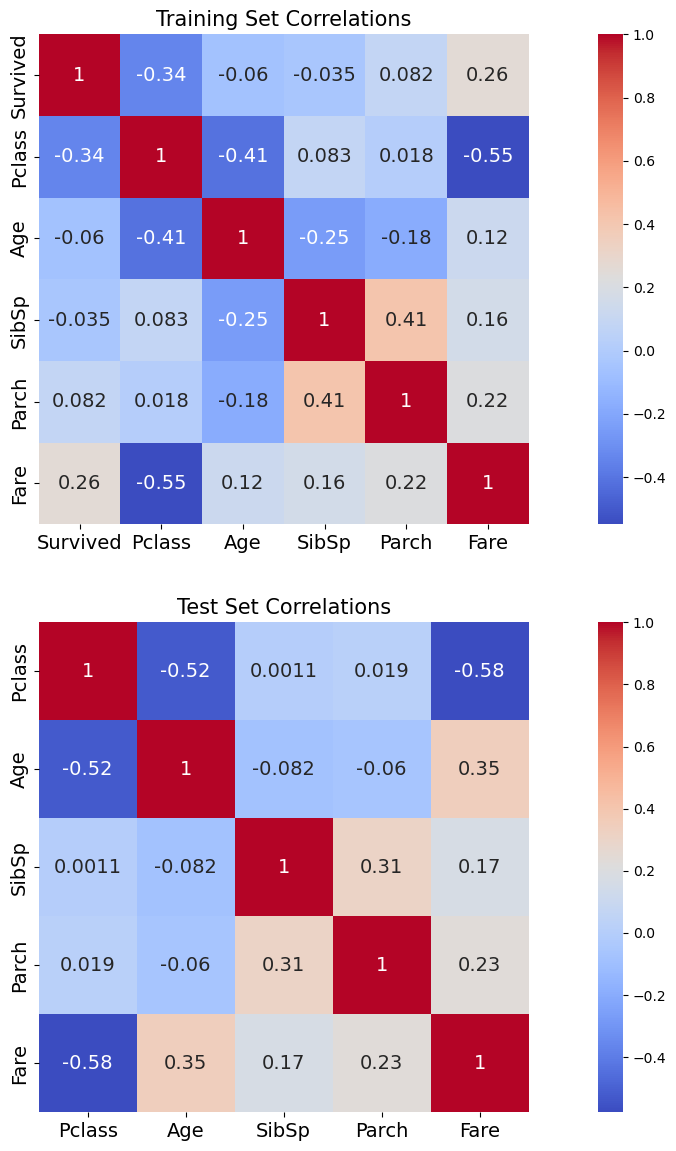

In [260]:
# create heatmaps
fig, axs = plt.subplots(nrows=2, figsize=(18, 14))

sns.heatmap(train_data.drop(columns=categorical_features).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(test_data.drop(columns=categorical_features).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

In [261]:
# removing categorical features for correlation
train_data_corr = train_data.drop(columns=['Name', 'Ticket', 'Sex', 'Embarked'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
test_data_corr = test_data.drop(columns=['Name', 'Ticket', 'Sex', 'Embarked'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

In [262]:
# rename columns and remove values, where correlation == 1
train_data_corr.rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation coefficient"}, inplace=True)
train_data_corr = train_data_corr.drop(train_data_corr[train_data_corr['Correlation coefficient'] == 1.0].index)

test_data_corr.rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation coefficient"}, inplace=True)
test_data_corr = test_data_corr.drop(test_data_corr[test_data_corr['Correlation coefficient'] == 1.0].index)

In [263]:
# train high correlations
train_corr = train_data_corr['Correlation coefficient'] > 0.1
train_data_corr[train_corr]

,Feature_1,Feature_2,Correlation coefficient
6,Fare,Pclass,0.549500
7,Pclass,Fare,0.549500
8,Parch,SibSp,0.414838
9,SibSp,Parch,0.414838
10,Age,Pclass,0.413583
11,Pclass,Age,0.413583
12,Survived,Pclass,0.338481
13,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
15,Survived,Fare,0.257307


In [264]:
# test high correlations
test_corr = test_data_corr['Correlation coefficient'] > 0.1
test_data_corr[test_corr]

,Feature_1,Feature_2,Correlation coefficient
5,Fare,Pclass,0.577487
6,Pclass,Fare,0.577487
7,Pclass,Age,0.524907
8,Age,Pclass,0.524907
9,Age,Fare,0.346706
10,Fare,Age,0.346706
11,Parch,SibSp,0.306895
12,SibSp,Parch,0.306895
13,Fare,Parch,0.230409
14,Parch,Fare,0.230409


Correlations between features and target

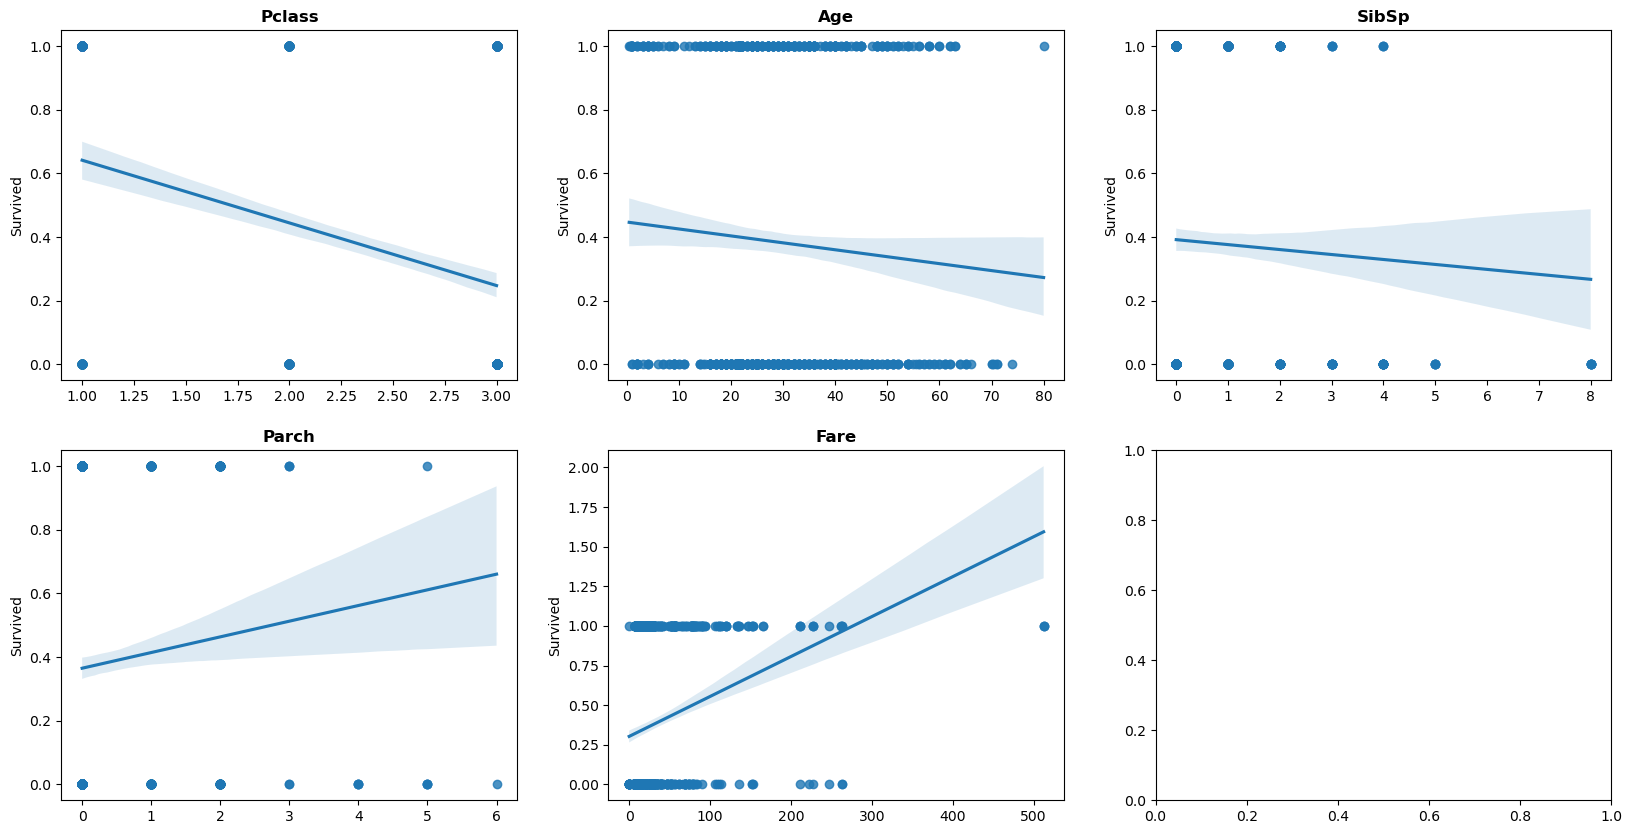

In [265]:
_, axis = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
sns.regplot(data=train_data, x='Pclass', y='Survived', ax=axis[0,0])
axis[0,0].set_title('Pclass', fontweight='bold')
axis[0,0].set_xlabel('')

sns.regplot(data=train_data, x='Age', y='Survived', ax=axis[0,1])
axis[0,1].set_title('Age', fontweight='bold')
axis[0,1].set_xlabel('')

sns.regplot(data=train_data, x='SibSp', y='Survived', ax=axis[0,2])
axis[0,2].set_title('SibSp', fontweight='bold')
axis[0,2].set_xlabel('')

sns.regplot(data=train_data, x='Parch', y='Survived', ax=axis[1,0])
axis[1,0].set_title('Parch', fontweight='bold')
axis[1,0].set_xlabel('')

sns.regplot(data=train_data, x='Fare', y='Survived', ax=axis[1,1])
axis[1,1].set_title('Fare', fontweight='bold')
axis[1,1].set_xlabel('')

plt.show()

Deleting some non-informative features

In [266]:
train_data = train_data.drop(columns=['Name', 'Ticket'])
test_data = test_data.drop(columns=['Name', 'Ticket'])

# Target distribution

In [267]:
survived = train_data['Survived'].value_counts()[1]
not_survived = train_data['Survived'].value_counts()[0]
survived_per = survived / train_data.shape[0] * 100
not_survived_per = not_survived / train_data.shape[0] * 100
print(f"Survived: {survived} - {survived_per:.2f}%, non-survived: {not_survived} - {not_survived_per:.2f}%")

Survived: 342 - 38.38%, non-survived: 549 - 61.62%


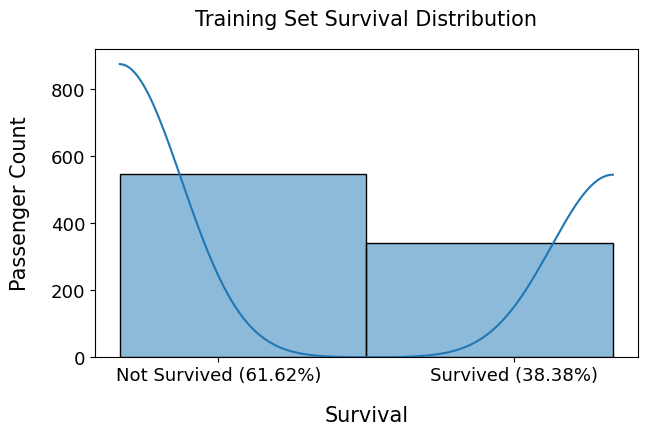

In [268]:
plt.figure(figsize=(7, 4))
sns.histplot(train_data['Survived'], bins=2 , kde=True)

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0.2, 0.8), [f"Not Survived ({not_survived_per:.2f}%)", f"Survived ({survived_per:.2f}%)"])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

# 2. Feature engineering

* Adding feature 'Family members'

In [269]:
train_data['Family_members'] = train_data['SibSp'] + train_data['Parch']
test_data['Family_members'] = test_data['SibSp'] + test_data['Parch']

* Adding feature 'Fare_range' based on percentilies

In [270]:
train_data['Fare'].describe(percentiles=[.25, .5, .75])

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [271]:
train_data['Fare_range'] = pd.cut(train_data['Fare'],
                                  bins=[0.0, 7.91, 14.45, 31, float('inf')],
                                  labels=['Cheap', 'Middle', 'Expensive', 'Very expensive'],
                                  right=False) # this is to include 0 in the range

test_data['Fare_range'] = pd.cut(test_data['Fare'],
                                  bins=[0.0, 7.91, 14.45, 31, float('inf')],
                                  labels=['Cheap', 'Middle', 'Expensive', 'Very expensive'],
                                  right=False)

# 3. Encoding categorical features

In [272]:
# Create columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories=[['Cheap', 'Middle', 'Expensive', 'Very expensive']]), ['Fare_range']),
        ('one_hot_encoder', OneHotEncoder(), ['Sex', 'Embarked', 'Pclass'])
    ])

# Create pipeline
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor)
    ])

In [273]:
# Apply the pipeline to DataFrame
train_data_transf = pipeline.fit_transform(train_data)
test_data_transf = pipeline.transform(test_data)

# Get column names after modification
# ordinal_encoder_categories = pipeline.named_steps['preprocessor'].named_transformers_['ordinal_encoder'].categories_[0]
one_hot_encoder_categories = pipeline.named_steps['preprocessor'].named_transformers_['one_hot_encoder'].get_feature_names_out(['Sex', 'Embarked', 'Pclass'])

# Convert the result back to DataFrame
train_data_transf = pd.DataFrame(train_data_transf, columns= ['Fare_Range'] + list(one_hot_encoder_categories))
test_data_transf = pd.DataFrame(test_data_transf, columns= ['Fare_Range'] + list(one_hot_encoder_categories))

# Set indexes
train_data_transf.index += 1
test_data_transf.index += 892

# Create a list of all column names
columns_train = list(train_data.columns) + list(train_data_transf.columns)
columns_test = list(test_data.columns) + list(test_data_transf.columns)

# Concatenate initial data with encoded data
train_data = pd.concat([train_data, train_data_transf], axis=1, ignore_index=True)
test_data = pd.concat([test_data, test_data_transf], axis=1, ignore_index=True)

# Assign column names
train_data.columns = columns_train
test_data.columns = columns_test

In [274]:
# Delete previously encoded columns
train_data.drop(columns=['Sex', 'Embarked', 'Pclass', 'Fare_range'], inplace=True)
test_data.drop(columns=['Sex', 'Embarked', 'Pclass', 'Fare_range'], inplace=True)

# 4. Splitting data into train, val and test 

In [275]:
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']
# split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=26)

X_test = test_data

In [276]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 14), (179, 14), (712,), (179,))

# 5. Scaling features

In [277]:
scaler = MinMaxScaler()
# normalize the data based on X_train
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

# convert normalized data into dataframes
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_val = pd.DataFrame(X_val_norm, columns=X_train.columns)
X_test = pd.DataFrame(X_test_norm, columns=X_train.columns)

In [278]:
X_train

,Age,SibSp,Parch,Fare,Family_members,Fare_Range,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.396833,0.125,0.166667,0.030254,0.2,0.666667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.421965,0.125,0.000000,0.040989,0.1,0.666667,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.233476,0.000,0.000000,0.015924,0.0,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.233476,0.375,0.333333,0.513342,0.5,1.000000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.308872,0.125,0.000000,0.030254,0.1,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.258608,0.000,0.166667,0.150855,0.1,1.000000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
708,0.522493,0.125,0.000000,0.050749,0.1,0.666667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
709,0.673285,0.125,0.500000,0.044893,0.4,0.666667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
710,0.384267,0.000,0.333333,0.321798,0.2,1.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# 6. Modeling 

# 1. Logistic regression

In [279]:
# train log reg
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# log reg prediction
log_reg_pred = logistic_regression.predict(X_val)

# accuracy
accuracy_log_reg = accuracy_score(y_val, log_reg_pred)
print(f"Accuracy: {accuracy_log_reg:.4f}")

# classification report
report = classification_report(y_val, log_reg_pred)
print(report)

Accuracy: 0.8156
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       116
           1       0.77      0.68      0.72        63

    accuracy                           0.82       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.82      0.81       179



# 2. SVC

In [280]:
# train svm
svm = SVC(random_state=26)
svm.fit(X_train, y_train)

# svm prediction
svm_pred = svm.predict(X_val)

# accuracy
accuracy_svm = accuracy_score(y_val, svm_pred)
print(f"Accuracy: {accuracy_svm:.4f}")

# classification report
report = classification_report(y_val, svm_pred)
print(report)

Accuracy: 0.7989
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       116
           1       0.81      0.56      0.66        63

    accuracy                           0.80       179
   macro avg       0.80      0.74      0.76       179
weighted avg       0.80      0.80      0.79       179



# 3. RandomForest

In [281]:
# train random forest
rf = RandomForestClassifier(random_state=26)
rf.fit(X_train, y_train)

# rf prediction
rf_pred = rf.predict(X_val)

# accuracy
accuracy_rf = accuracy_score(y_val, rf_pred)
print(f"Accuracy: {accuracy_rf:.4f}")

# classification report
report = classification_report(y_val, rf_pred)
print(report)

Accuracy: 0.8045
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       116
           1       0.73      0.71      0.72        63

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



* Optuna parameters (The process is at the end of this document)

In [282]:
params = {'n_estimators': 230,
          'criterion': 'entropy',
          'max_depth': 11,
          'min_samples_split': 4,
          'min_samples_leaf': 2,
          'random_state': 26}
# Best value (Accuracy): 0.8324022346368715

In [283]:
# train random forest with optuna params
rf_optuna = RandomForestClassifier(**params)
rf_optuna.fit(X_train, y_train)

# rf prediction
rf_pred = rf_optuna.predict(X_val)

# accuracy
accuracy_rf = accuracy_score(y_val, rf_pred)
print(f"Accuracy: {accuracy_rf:.4f}")

# classification report
report = classification_report(y_val, rf_pred)
print(report)

Accuracy: 0.8324
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       116
           1       0.79      0.71      0.75        63

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



# 4. Boosting

# 4.1. XGBoost

In [284]:
# train xgboost
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)

# xgboost prediction
xgboost_pred = xgboost.predict(X_val)

# accuracy
accuracy_xgboost = accuracy_score(y_val, xgboost_pred)
print(f"Accuracy: {accuracy_xgboost:.4f}")

# classification report
report = classification_report(y_val, xgboost_pred)
print(report)

Accuracy: 0.8045
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       116
           1       0.72      0.73      0.72        63

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179



* More advanced XGBoost training

In [285]:
train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=y_val)

hyperparams = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eta': 0.1, #lr
    'min_child_weight': 8,
    'max_depth': 18,
    'subsample': 0.9,
    # 'colsample_bytree': 0.9,
    'max_leaves': 38,
    'reg_alpha': 0.8,
    'random_state':26
}

xgboost_model = xgb.train(params=hyperparams,
                          dtrain=train_data,
                          evals=[(train_data, 'train'), (val_data, 'val')],
                          num_boost_round=1000,
                          early_stopping_rounds=200)

X_val_dmatrix = xgb.DMatrix(X_val)
y_pred_xgboost_model = xgboost_model.predict(X_val_dmatrix)
y_pred_xgboost_model = np.where(y_pred_xgboost_model > 0.5, 1, 0)

accuracy_xgboost = accuracy_score(y_val, y_pred_xgboost_model)
print(f"Accuracy: {accuracy_xgboost:.4f}")

[0]	train-logloss:0.62934	val-logloss:0.61926
[1]	train-logloss:0.59663	val-logloss:0.59170
[2]	train-logloss:0.56971	val-logloss:0.57085
[3]	train-logloss:0.54769	val-logloss:0.55367
[4]	train-logloss:0.52805	val-logloss:0.53743
[5]	train-logloss:0.51096	val-logloss:0.52287
[6]	train-logloss:0.49543	val-logloss:0.51242
[7]	train-logloss:0.48356	val-logloss:0.50385
[8]	train-logloss:0.47242	val-logloss:0.49624
[9]	train-logloss:0.46280	val-logloss:0.49004
[10]	train-logloss:0.45440	val-logloss:0.48514
[11]	train-logloss:0.44670	val-logloss:0.48058
[12]	train-logloss:0.44047	val-logloss:0.47714
[13]	train-logloss:0.43525	val-logloss:0.47507
[14]	train-logloss:0.43002	val-logloss:0.47305
[15]	train-logloss:0.42532	val-logloss:0.47139
[16]	train-logloss:0.42079	val-logloss:0.47071
[17]	train-logloss:0.41316	val-logloss:0.46636
[18]	train-logloss:0.40933	val-logloss:0.46589
[19]	train-logloss:0.40298	val-logloss:0.46221
[20]	train-logloss:0.39703	val-logloss:0.45844
[21]	train-logloss:0.39

[26]	train-logloss:0.37876	val-logloss:0.45211
[27]	train-logloss:0.37650	val-logloss:0.45240
[28]	train-logloss:0.37424	val-logloss:0.45225
[29]	train-logloss:0.37219	val-logloss:0.45309
[30]	train-logloss:0.37018	val-logloss:0.45487
[31]	train-logloss:0.36887	val-logloss:0.45505
[32]	train-logloss:0.36726	val-logloss:0.45573
[33]	train-logloss:0.36558	val-logloss:0.45526
[34]	train-logloss:0.36421	val-logloss:0.45616
[35]	train-logloss:0.36290	val-logloss:0.45629
[36]	train-logloss:0.36124	val-logloss:0.45777
[37]	train-logloss:0.35984	val-logloss:0.45715
[38]	train-logloss:0.35871	val-logloss:0.45810
[39]	train-logloss:0.35786	val-logloss:0.45802
[40]	train-logloss:0.35666	val-logloss:0.45753
[41]	train-logloss:0.35529	val-logloss:0.45831
[42]	train-logloss:0.35421	val-logloss:0.45938
[43]	train-logloss:0.35301	val-logloss:0.45911
[44]	train-logloss:0.35201	val-logloss:0.46072
[45]	train-logloss:0.35091	val-logloss:0.46073
[46]	train-logloss:0.35000	val-logloss:0.46082
[47]	train-lo

# 4.2. LGBM

In [286]:
lgbm_class = lgbm.LGBMClassifier(random_state=26)

# train lgbm
lgbm_class.fit(X_train, y_train)

# lgbm prediction
lgbm_pred = lgbm_class.predict(X_val)

# accuracy
accuracy_lgbm = accuracy_score(y_val, lgbm_pred)
print(f"Accuracy: {accuracy_lgbm:.4f}")

# classification report
report = classification_report(y_val, lgbm_pred)
print(report)

[LightGBM] [Info] Number of positive: 279, number of negative: 433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391854 -> initscore=-0.439526
[LightGBM] [Info] Start training from score -0.439526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

* Optuna parameters (The process is at the end of this document)

In [287]:
params = {'n_estimators': 541,
          'num_leaves': 21,
          'max_depth': 10,
          'min_data_in_leaf': 38,
          'learning_rate': 0.06403173968671128,
          'lambda_l1': 0.5889038702719135,
          'random_state': 26}
# Best value (Accuracy): 0.8603351955307262

In [288]:
# train lgbm with optuna params
lgbm_optuna =  lgbm.LGBMClassifier(**params)
lgbm_optuna.fit(X_train, y_train)

# lgbm prediction
lgbm_pred = lgbm_optuna.predict(X_val)

# accuracy
accuracy_lgbm = accuracy_score(y_val, lgbm_pred)
print(f"Accuracy: {accuracy_lgbm:.4f}")

# classification report
report = classification_report(y_val, lgbm_pred)
print(report)

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=0.5889038702719135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5889038702719135
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=0.5889038702719135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5889038702719135
[LightGBM] [Info] Number of positive: 279, number of negative: 433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391854 -> initscore=-0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

* More advanced LGBM training

[LightGBM] [Info] Number of positive: 279, number of negative: 433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391854 -> initscore=-0.439526
[LightGBM] [Info] Start training from score -0.439526
Training until validation scores don't improve for 200 rounds
[20]	train's binary_logloss: 0.622844	val's binary_logloss: 0.615981
[40]	train's binary_logloss: 0.584146	val's binary_logloss: 0.587516
[60]	train's binary_logloss: 0.551587	val's binary_logloss: 0.563284


d:\IT\Anaconda\envs\it_academy\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[80]	train's binary_logloss: 0.523116	val's binary_logloss: 0.541792
[100]	train's binary_logloss: 0.49884	val's binary_logloss: 0.524225
[120]	train's binary_logloss: 0.477996	val's binary_logloss: 0.509788
[140]	train's binary_logloss: 0.459934	val's binary_logloss: 0.497911
[160]	train's binary_logloss: 0.44348	val's binary_logloss: 0.487775
[180]	train's binary_logloss: 0.428553	val's binary_logloss: 0.479126
[200]	train's binary_logloss: 0.4157	val's binary_logloss: 0.472615
[220]	train's binary_logloss: 0.404147	val's binary_logloss: 0.467087
[240]	train's binary_logloss: 0.393509	val's binary_logloss: 0.462044
[260]	train's binary_logloss: 0.384149	val's binary_logloss: 0.457135
[280]	train's binary_logloss: 0.375899	val's binary_logloss: 0.45324
[300]	train's binary_logloss: 0.368743	val's binary_logloss: 0.45027
[320]	train's binary_logloss: 0.362193	val's binary_logloss: 0.44784
[340]	train's binary_logloss: 0.356368	val's binary_logloss: 0.445643
[360]	train's binary_logloss

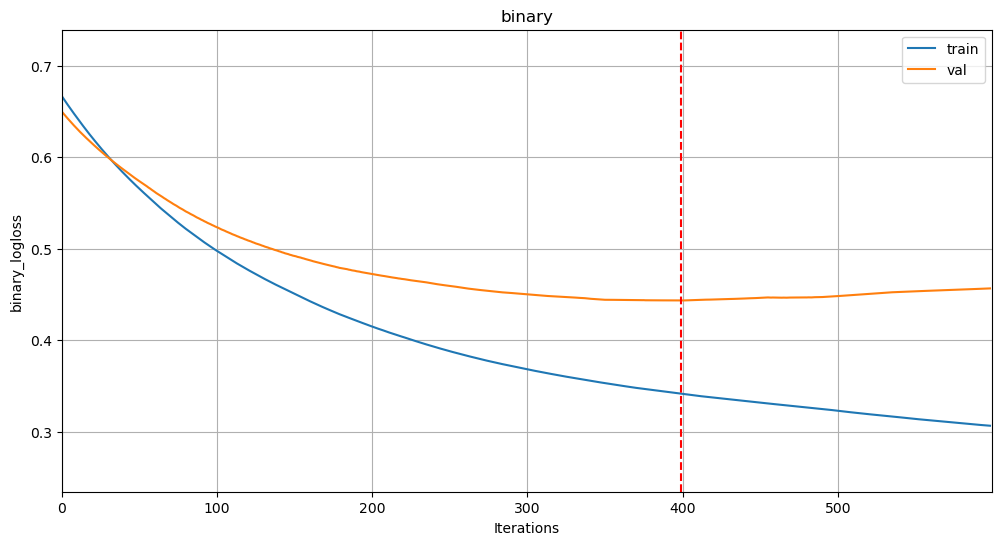

Accuracy: 0.8324
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       116
           1       0.80      0.70      0.75        63

    accuracy                           0.83       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.83      0.83      0.83       179



In [289]:
train_dataset = lgbm.Dataset(data=X_train, label=y_train)
val_dataset = lgbm.Dataset(data=X_val, label=y_val)

mlflow.set_experiment("Advanced LGBM training")
mlflow.set_tracking_uri("file://D:/IT/Data_science/kaggle/Titanic - Machine Learning from Disaster/mlruns")

with mlflow.start_run(run_name='Final params'):
    hyperparams = {
        'objective': 'binary',
        # 'metric': ['binary_logloss'],
        'n_estimators': 1_000,
        'num_leaves': 16,
        'max_depth': 16,
        'min_data_in_leaf': 18,
        'learning_rate': 0.005,
        'lambda_l1': 0.1,
        'random_state': 26
    }

    training_history = {}

    callbacks = [
        lgbm.log_evaluation(20),
        lgbm.record_evaluation(training_history),
        lgbm.early_stopping(200)
    ]

    lgbm_model = lgbm.train(params=hyperparams,
                            train_set=train_dataset,
                            valid_sets=[train_dataset, val_dataset],
                            valid_names=['train', 'val'],
                            callbacks=callbacks)

    _, axis = plt.subplots(figsize=(12,6))
    lgbm.plot_metric(training_history, metric='binary_logloss', title='binary', ax=axis)
    plt.axvline(lgbm_model.best_iteration, c='r', linestyle='--')
    plt.show()

    lgbm_model_pred = lgbm_model.predict(X_val)
    lgbm_model_pred_binary = np.where(lgbm_model_pred > 0.5, 1, 0)

    # accuracy
    accuracy_lgbm_adv = accuracy_score(y_val, lgbm_model_pred_binary)
    print(f"Accuracy: {accuracy_lgbm_adv:.4f}")

    # classification report
    report = classification_report(y_val, lgbm_model_pred_binary)
    print(report)

    mlflow.log_metric('Accuracy', accuracy_lgbm_adv)
    mlflow.log_params(hyperparams)

    mlflow.end_run()

# Optuna for Random Forest

In [290]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 9),
        'random_state': 26
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

This is commented out so as not to clutter up the output. The results are listed below.

In [291]:
study = optuna.create_study(direction='maximize')
# study.optimize(objective_rf, n_trials=100)

# best_params = study.best_params
# best_value = study.best_value

# print("Best parameters:", best_params)
# print("Best value (Accuracy):", best_value)

[I 2024-03-25 18:45:53,275] A new study created in memory with name: no-name-e3ca59ce-5824-4eaa-8028-a7a737ad94b6


In [292]:
# Best parameters: {'n_estimators': 230, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2}
# Best value (Accuracy): 0.8324022346368715

# Optuna for LGBM

In [293]:
def objective(trial):
    params = {
        'objective': 'binary',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 8, 40),
        'max_depth': trial.suggest_int('max_depth', -1, 30),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 10)
        
    }

    model = lgbm.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

This is commented out so as not to clutter up the output. The results are listed below.

In [294]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_value = study.best_value

# print("Best parameters:", best_params)
# print("Best value (Accuracy):", best_value)

In [295]:
# Best parameters: {'n_estimators': 541, 'num_leaves': 21, 'max_depth': 10, 'min_data_in_leaf': 38, 'learning_rate': 0.06403173968671128, 'lambda_l1': 0.5889038702719135}
# Best value (Accuracy): 0.8603351955307262

# Submission

In [296]:
# so that indexes were the same
new_index = range(892, 892 + len(X_test))
X_test.index = new_index

In [302]:
submission = pd.read_csv('gender_submission.csv')

assert len(X_test) == len(submission)
assert np.all(submission['PassengerId'] == X_test.index)

lgbm_pred = lgbm_model.predict(X_test)
lgbm_pred = np.where(lgbm_pred > 0.5, 1, 0)

submission['Survived'] = lgbm_pred
submission.to_csv("submission.csv", index=False)

print("Submission file is created successfully")

Submission file is created successfully


# Conclusion

Top models:
1. Advanced LGBM training
2. Random Forest with Optuna
3. Advanced XGBoost training